In [1]:
!pip install nltk
!pip install tensorflow
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.4.24-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (763 kB)
  Using cached tensorflow-2.8.0-cp39-cp39-manylinux2010_x86_64.whl (497.6 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_io_gcs_filesystem-0.25.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-14.0.1-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached grpcio-1.46.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunpar

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import en_core_web_sm
nlp = en_core_web_sm.load()

import string
from string import digits

from spacy.lang.en.stop_words import STOP_WORDS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
train = pd.read_csv("SRC_projects/nlp_disaster/train.csv")
test = pd.read_csv("SRC_projects/nlp_disaster/test.csv")
sample_sub = pd.read_csv("SRC_projects/nlp_disaster/sample_submission.csv")

print("nombre de lignes pour le train set: ",train.shape[0])
display(train.head(2))
print("nombre de lignes pour le test set: ",test.shape[0])
display(test.head(2))

print("Pourcentage de valeurs manquantes sur le train set:")
print(train.isna().sum()*100 / train.shape[0])
print("Pourcentage de valeurs manquantes sur le test set:")
print(test.isna().sum()*100 / test.shape[0]) 
#On peut déja enlever la colonne location
#Je vais faire un dropna pour enlever les valeurs manquantes, la colonne keyword pourra m'être utile

nombre de lignes pour le train set:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


nombre de lignes pour le test set:  3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


Pourcentage de valeurs manquantes sur le train set:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64
Pourcentage de valeurs manquantes sur le test set:
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


<AxesSubplot:xlabel='target', ylabel='count'>

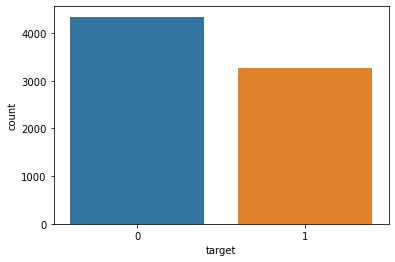

In [4]:
sns.countplot(x=train['target'])

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
table = str.maketrans('', '', digits)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=200)

In [7]:
def cleaning_encoding(df):
    
    df = df.drop('location', axis=1) # supprime la colonne location
    df = df.dropna() # j'enlève les lignes possédant des valeurs nulles
    df = df.reset_index() # je supprime l'index qui n'était pas ordonné suite au dropna
    df = df.drop('id',axis=1) # j'enlève la colonne id
    df = df.drop('index', axis=1) # et la colonne index
    
    df['text_clean'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) 
    #J'enlève les URLS

    df['text_clean'] = df['text_clean'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
    #Je viens d'enlever toutes les caractères qui ne sont pas alphanumériques

    

    df['text_clean'] = df['text_clean'].apply(lambda x: x.translate(table)).apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower().strip())
    #str.maketrans('', '', digits) nous permet d'enlever les numbers
    #translate(str.maketrans('', '', string.punctuation)).lower() nous permet d'enlever la ponctuation et les majuscules 

    df['text_clean'] = df['text_clean'].apply(lambda x:" ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
    #tokenization et lemmatization

    

    tokenizer.fit_on_texts(df.text_clean)
    df['text_encoded'] = tokenizer.texts_to_sequences(df.text_clean) #Nouvelle colonne, le texte est maintenant encodé

    df['len_text_encoded'] = df['text_encoded'].apply(lambda x: len(x))
    df = df[df['len_text_encoded']!=0] #nouvelle colonne avec la longueur de chaque liste de texte encodé
    
    return df.head()

In [8]:
train_cleaned = cleaning_encoding(train)
test_cleaned = cleaning_encoding(test)

In [9]:
display(train_cleaned.head())
print(train.shape[0], "rows")

,keyword,text,target,text_clean,text_encoded,len_text_encoded
1,ablaze,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal rt,"[127, 46]",2
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze break newsnigeria flag set ablaze aba,"[85, 128]",2
3,ablaze,Crying out for more! Set me ablaze,0,cry set ablaze,[128],1
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze,"[21, 176]",2
5,ablaze,@PhDSquares #mufc they've built so much hype a...,0,phdsquare mufc ve build hype new acquisition d...,"[86, 6, 128]",3


7613 rows


In [10]:
display(test_cleaned.head())
print(test.shape[0], "rows")

,keyword,text,text_clean,text_encoded,len_text_encoded
0,ablaze,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news ...,"[8, 2, 75]",3
2,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwaûªs marriage c...,[128],1
3,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,[199],1
5,ablaze,beware world ablaze sierra leone &amp; guap.,beware world ablaze sierra leone amp guap,"[41, 4]",2
6,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,burn man ablaze turban diva etsy,"[9, 27]",2


3263 rows


In [11]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_cleaned.text_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_cleaned.text_encoded, padding="post")

In [12]:
full_train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train_cleaned.target.values))
full_test_ds = tf.data.Dataset.from_tensor_slices((test_pad))

In [13]:
# Train test split
TAKE_SIZE = int(0.7*train_cleaned.shape[0])

train_cleaned_data = full_train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_cleaned_data = train_cleaned_data.batch(64)

val_data = full_train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(64)

In [14]:
for tweet, target in train_cleaned_data.take(200):
    print(tweet, target)

tf.Tensor(
[[127  46   0]
 [ 85 128   0]
 [128   0   0]], shape=(3, 3), dtype=int32) tf.Tensor([0 1 0], shape=(3,), dtype=int64)


In [15]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

In [27]:
vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
            Embedding(vocab_size+1, 64, input_shape=[train_pad.shape[1]], name='embedding'),
            LSTM(units=64, return_sequences=True),
            LSTM(units=32, return_sequences=False),
            Dense(16, activation='relu'),
            Dense(8, activation='relu'),

            Dense(5, activation="softmax", name="last")])

In [28]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 64)             1215872   
                                                                 
 lstm_8 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 last (Dense)                (None, 5)                 45        
                                                                 
Total params: 1,262,021
Trainable params: 1,262,021
No

In [29]:
optimizer = tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [31]:
model_lstm.fit(train_cleaned_data,
              epochs=100,
              validation_data=val_data)

Epoch 1/100
1/1 [==============================] - 0s 38ms/step - loss: 1.5431 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.6288 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.6307 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 1.5306 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.6326 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 1.5237 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.6360 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 1.5160 - sparse_categorical_accuracy: 0.3333 - val_loss: 1.6408 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 1.5074 - sparse_ca